# Presets

## Imports

In [1]:
sys.path.append('/home/spike/') #path to ecogy

In [2]:
#basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#widgets
import ipywidgets as widgets
from ipywidgets import interactive, fixed, VBox, HBox

import ecogy

## Upload data

In [3]:
path_to_preprocessed = '/home/spike/ecogy/epochs/'
# path_to_preprocessed = '/media/data/sINBOX/epochs/'

def upload_epochs(rec):
    if rec == ' ':
        pass
    else:
        with open(path_to_preprocessed + f'{rec}', 'rb') as f:
            epochs = pickle.load(f)
        return epochs

opt = os.listdir(path_to_preprocessed)
opt.sort()
ddrec = widgets.Dropdown(options=opt,
                        description='Rec:',
                        disabled=False)

wrec = widgets.interactive(upload_epochs, rec=ddrec)
display(wrec)

interactive(children=(Dropdown(description='Rec:', options=('2019-10-17_22-19-20_P15_IC1000.pkl', '2019-10-18_…

In [4]:
ep, lp = wrec.result

## Functions

### get_av

In [5]:
def get_av(epochs, reref=True, baseline=True, target_epoch='all'):
    
    #Signal preporcessing
    if reref:
        epochs = epochs.copy().set_eeg_reference()
    if baseline:
        epochs = epochs.copy().apply_baseline()
    
    if target_epoch == 'all':
        pass
    else:
        epochs = epochs.drop(np.delete(np.arange(epochs.get_data().shape[0]), int(target_epoch)))
        
    #Averaging:    
    av = epochs.copy().average()
    
    return av

### plot_av

In [6]:
def plot_av(av, tmin=0.025, dt=0.01, v='auto', peak='N', ax=None):
    
    # In the interactive mode pass a figure, overwise create a new figure
    if ax:
        ax.clear()
        plt.sca(ax)
    else:
        plt.figure(figsize=[9,3])
        plt.xlabel('time, s')
        plt.ylabel('amplitude, mV')
        plt.tight_layout()
        
    assert av.data.shape[1] > av.data.shape[0], 'Invalid av array shape'
    
    #Plot av
    plt.plot(av.times, av.data.T , color='k', lw=0.1)
    
#     if y == None:
#         ymin = av.data.T.min()
#         ymax = av.data.T.max()
#         y = np.round(np.max([np.abs(ymin), np.abs(ymax)]))
#     ymin = -y
#     ymax = y
#     plt.yticks([ymin, 0, ymax])

    if v == 'auto':
        v = get_v(av)
    else:
        v = int(v)
        
    plt.yticks([-v, 0, v])

    #Find the channel with maximum absolute amplitude on the interval start--stop:
    zero_ts = np.where(av.times == 0)[0][0]
    ts_min = int(zero_ts + tmin*av.info['sfreq'])
    ts_max = ts_min + int(dt*av.info['sfreq'])

    if peak=='P': 
        plt.plot(av.times, av.data.T[:, np.argmax((av.data[:,ts_min:ts_max]).max(axis=1))], color='k')
        plt.text(0,50, f'{av.ch_names[np.argmax((av.data[:,ts_min:ts_max]).max(axis=1))]}')
        plt.xlim([0.0,0.1])
    if peak=='N': 
        plt.plot(av.times, av.data.T[:, np.argmin((av.data[:,ts_min:ts_max]).min(axis=1))], color='k')
        plt.text(0,50, f'{av.ch_names[np.argmin((av.data[:,ts_min:ts_max]).min(axis=1))]}')
        plt.xlim([-0.1,0.4])
        
    
    # Plot lines that specify 5 ms intervals
    lines = np.arange(0.0, np.round(av.times[-1],2), 0.005)
    plt.vlines(lines, -v, v, color='r', lw=0.2)
    
    
    #Fill the area, where signal will be averaged for a topographic map
    tmax = tmin + dt
    plt.fill_between([tmin, tmax], -v, v, color='r', alpha=0.4)

### get_amplitudes

In [7]:
def get_amplitudes(av, tmin, dt=0.005, statistics='mean'):
    
    tmax = tmin + dt
    
    if statistics == 'mean': 
        amplitudes = av.copy().crop(tmin, tmax).data.mean(-1)
    elif statistics == 'min':
        amplitudes = av.copy().crop(tmin, tmax).data.min(-1) 
    
    return amplitudes

### interpolate

In [8]:
from scipy.interpolate import griddata

In [9]:
def interpolate(amplitudes, probe, method='cubic'):
    
    points = np.array([ep.x, ep.y])
    
    xi, yi = np.mgrid[0:ep.x.max()+1:1, 0:ep.y.max()+1:1]
    interp_points = np.vstack((np.squeeze(xi.T.reshape(-1,1)), np.squeeze(yi.T.reshape(-1,1))))
    
    interp_amplitudes =  griddata(points=points.T, values=amplitudes, xi=interp_points.T, method=method)
        
    interp_amplitudes = interp_amplitudes.reshape(2001,3601)

    return interp_amplitudes

### plot_map

In [10]:
def plot_map(amplitudes,
             probe, 
             v=None,
             ax=None):
       
    plt.sca(ax)

    plt.imshow(amplitudes, extent=[0, probe.x.max(), probe.y.max(), 0], cmap='RdYlBu_r', vmin=-v, vmax=v)
    plt.contour(amplitudes, levels=np.arange(-v, v, v/10), colors='k', alpha=0.1)

    plt.gca().xaxis.tick_top()
    plt.title(None, loc='left')
    plt.title(None, loc='right')
    plt.ylim([-200, probe.y.max()+ 200])
    plt.xlim([-200, probe.x.max()+ 200])

### plot_channels

In [11]:
def plot_channels(av, probe,ax=None):
    
    plt.sca(ax)
    
    H = probe.x[1]-probe.x[0] #interval between channels
    
    t1, t2 = int(av.data.shape[1]/3), int(av.data.shape[1]/3 + 2*av.data.shape[1]/15) #200
    
    for i in range(len(probe.channels)):
        time = np.linspace(probe.x[i], 
                           probe.x[i]+ H/2.2,
                           av.data[0,t1:t2].shape[0])
        
        
        
        sig = H*(av.data[i, t1:t2])/np.max((np.abs(av.data.min()), np.abs(av.data.max())))  + ep.y[i] 
        
        plt.plot(time, sig, 'k', lw=1, label='trace')

### visibility

In [12]:
def visibility(show_labels=True, ax=None):
    
    plt.sca(ax)

    for txt in ax.texts:
        txt.set_visible(show_labels)
    for tr in [l for l in ax.lines if l.get_label() == 'trace']:
        tr.set_visible(not show_labels)
    

### get_v

In [13]:
def get_v(av):
    return np.round(np.max([np.abs(av.data.T.min()), np.abs(av.data.T.max())]))

### viewer

In [14]:
def viewer(probe, 
           tmin=0.05, 
           dt=0.01,
           
           reref=True, 
           baseline=True,
           target_epoch='all', 
           
           peak='P',
           statistics='mean',
           method='linear',
           
           v='auto', 
           show_labels=True, 
           
           axes=[]):
    
    
    
    tmin = tmin/1000
    dt = dt/1000
    
    axes[0].clear()
    axes[1].clear()
    
    #.1 Average epoch
    av = get_av(probe.epochs, target_epoch=target_epoch, reref=reref, baseline=baseline)
    
    
    #.2 Amplitides
    amplitudes = get_amplitudes(av, tmin=tmin, dt=dt, statistics=statistics)
    interp_amplitudes = interpolate(amplitudes, probe, method=method)
    
    if v == 'auto':
        v = get_v(av)
    else:
        v = int(v)
    
    
    #.3 Plots
    
       
    plot_av(av, tmin=tmin, dt=dt, v=v, ax=axes[0], peak=peak)
    
    probe.show(ax=axes[1])
    
    plot_map(interp_amplitudes,
             probe, 
             v=v,
             ax=axes[1])
    
    plot_channels(av, 
                  probe, 
                  ax=axes[1])
    
    visibility(show_labels=show_labels, 
               ax=axes[1])
    
    
    plt.title(get_title())
    plt.tight_layout()
    

# Topographic Maps

## Widgets

In [15]:
plt.ioff()
fig_map, axes = plt.subplots(2,1, gridspec_kw={'height_ratios': [4,10]})
fig_map.set_size_inches(7,7)
plt.ion()

# import matplotlib
# matplotlib.rcParams['contour.negative_linestyle'] = 'solid'


#Preprocessing box

wreref = widgets.Checkbox(value=True)

wbaseline = widgets.Checkbox(description='baseline', value=True)

wstatistics = widgets.Dropdown(options=['mean', 'min'])

pbox = widgets.HBox([wreref, wbaseline, wstatistics])


wv = widgets.Text(value='auto', continuous_update=False)

wpeak = widgets.Text(description='peak',
                      value='N',
                     layout=widgets.Layout(width = '120px'),
                    continuous_update=False)


wshowlabels = widgets.Checkbox(description='ch-s', 
                            value=False,
                           layout=widgets.Layout(width = '200px'))

wmethod = widgets.Dropdown(options=['linear', 'cubic'])

visbox = widgets.HBox([wshowlabels, wpeak, wmethod, wv])



#Timebox

wauto = widgets.Button(description='auto', layout=widgets.Layout(width = '60px'))


def on_button_clicked(b):
    viewer(fig_map, f_epochs, 
           df_probe, 
           reref=wreref.value, 
           baseline=wbaseline.value, 
           statistics=wstatistics.value, 
           tmin=None, 
           dt=wdt.value, 
           noisy=noisy,
           v=wv.value,
           show_channels=wshowchs.value,
           method=wmethod.value,
           target_chs=target_chs
          )

wauto.on_click(on_button_clicked)

wplay = widgets.Play(
    value=50,
    min=0,
    max=300,
    step=1,
    interval=3000, #2000
    disabled=False
)

wtmin = widgets.IntSlider(value=50,
                          min=0,
                          max=300,
                          step=1,
                          continuous_update=False,
                          layout=widgets.Layout(width = '500px'))


widgets.jslink((wplay, 'value'), (wtmin, 'value'))

wdt = widgets.IntSlider(value=2,
                          min=0,
                          max=50,
                          step=1,
                          continuous_update=False,
                          readout_format='.0f')


tbox = widgets.HBox([wauto, wplay, wtmin, wdt])


#Save box

wstim = widgets.Dropdown(options=['','BC', 'eAC', 'AC', 'IC', 'CO', 'SS', 'VE', 'VIS'])

wcomment = widgets.Text()

wsave = widgets.Button(description='save')


def get_title():
    title = f'{wrec.children[0].value[:-4]}_\
rrf_{wreref.value}_bln_{wbaseline.value}_{wstatistics.value}_\
t_{wtmin.value}-{wtmin.value+wdt.value}ms_\
stim_{wstim.value}{wcomment.value}_N{ep.epochs.get_data().shape[0]}'
    fig_map.axes[0].set_title(title)
    return title

def on_button_clicked(b):
    save_figure(fig_map, get_title(), pdf=wpdf.value)
#     save_as_pdf(fig, f'/media/data/sINBOX/{get_title()}.pdf')

wsave.on_click(on_button_clicked)

wpdf = widgets.Checkbox(description='pdf', value=False)

savebox = HBox([wstim, wcomment, wsave, wpdf])

wepoch = widgets.Text(value='all', continuous_update=False)
ebox = HBox([wepoch])


#Interactive

w = widgets.interactive(viewer,
                        
                        probe=widgets.fixed(ep),
                        
                        tmin=wtmin, 
                        dt=wdt,
                        
                        reref=wreref,
                        baseline=wbaseline,
                        target_epoch = wepoch,
                       
                        peak=wpeak,
                        statistics=wstatistics,
                        method=wmethod,
                        
                        show_labels=wshowlabels,
                        v=wv,
                        axes=widgets.fixed(axes))


tab = widgets.Tab()
tab_contents = [tbox, pbox, ebox, visbox, savebox]
tab.children = tab_contents

tab.set_title(0, 'Time')
tab.set_title(1, 'Preprocessing')
tab.set_title(2, 'Epoch #')
tab.set_title(3, 'Visualization')
tab.set_title(4, 'Save')

# display(tab)
# fig_map

## Display

<IPython.core.display.Javascript object>


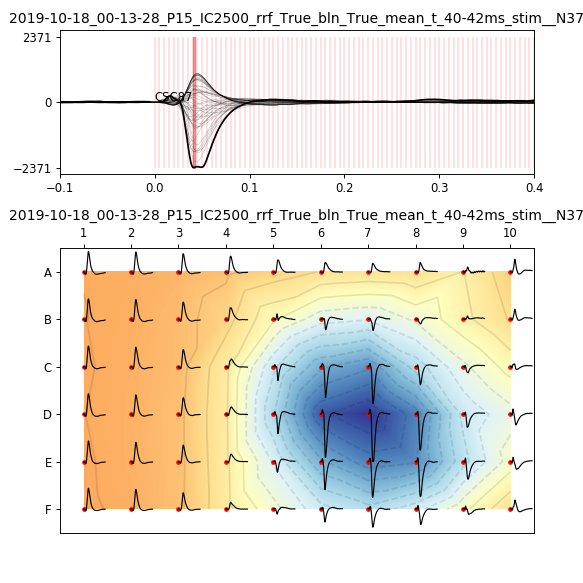

In [16]:
display(tab)
fig_map